# Covid-19 epidemiologic data

In this tutorial, we will use Wavy to prepare and analyze WHO data on COVID-19, which can be downloaded [here](https://covid19.who.int/WHO-COVID-19-global-data.csv).

First, we will import the necessary libraries:

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

import sys
sys.path.append('../')

from wavy import panel
from wavy import frequency
from wavy import utils
from wavy import model

After that, we will load the .csv file into a Pandas DataFrame and take a look at its first few rows:

In [8]:
csv_path = '/home/amandacasadei/Downloads/WHO-COVID-19-global-data.csv'
df = pd.read_csv('../data/covid.csv')

In [9]:
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


We can add a column to our dataframe with the day of the week the column "Date_reported" refers to:

In [10]:
df['Date_reported'] = pd.to_datetime(df['Date_reported'])
df['Day_of_week'] = df['Date_reported'].dt.day_name()

In [11]:
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Day_of_week
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0,Friday
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0,Saturday
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0,Sunday
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0,Monday
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0,Tuesday


### Exploratory data analysis and data preparation:

Next, we will perform an EDA on the data in order to elucidate its behavior. In the cell below, you can change the name of the variable "country" to see the descriptive statistics and charts for new and cumulative cases, as well as new and cumulative deaths.

           New_cases  Cumulative_cases   New_deaths  Cumulative_deaths
count     739.000000      7.390000e+02   739.000000         739.000000
mean    30445.906631      9.844434e+06   838.886333      272639.556157
std     25891.145488      8.287786e+06   804.010190      227954.584585
min      -573.000000      0.000000e+00     0.000000           0.000000
25%      9245.500000      1.558042e+06   223.000000       63719.500000
50%     25565.000000      7.753752e+06   674.000000      196561.000000
75%     47034.000000      1.893590e+07  1186.500000      529359.500000
max    150106.000000      2.249952e+07  4249.000000      619937.000000


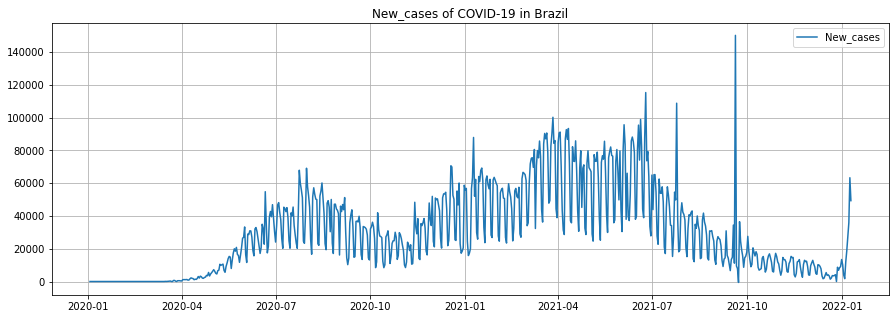

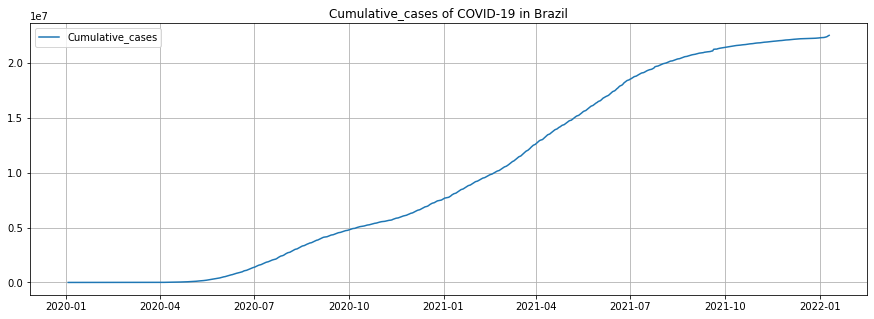

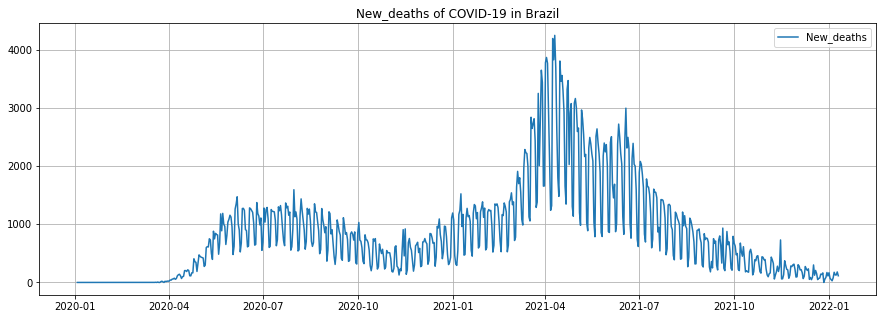

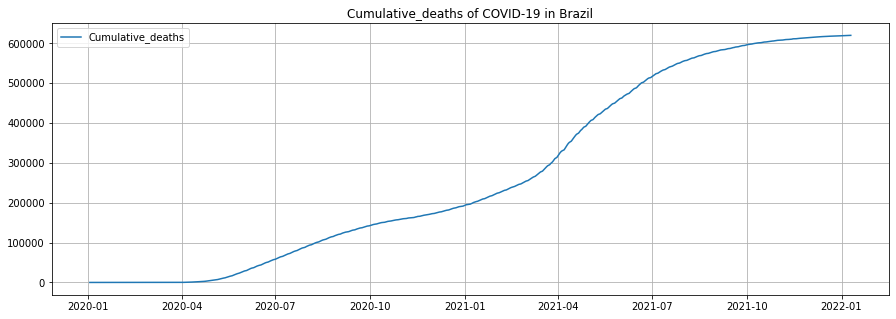

In [12]:
country = "Brazil"

aux_df = df.loc[df["Country"] == country]
aux_df = aux_df.set_index("Date_reported")
aux_df.index = pd.to_datetime(aux_df.index)


print(aux_df.describe())

for metric in ["New_cases", "Cumulative_cases", "New_deaths", "Cumulative_deaths"]:   
    plt.figure(figsize=(15, 5))
    plt.plot(aux_df[metric])
    plt.title(f'{metric} of COVID-19 in {country}')
    plt.grid(True)
    plt.legend([metric])
    plt.show()

The data columns that are the most interesting for the purpose of time series forecasting and will therefore be used in this tutorial from now on are **"New_cases"** and **"New_deaths"**. Please, note that negative numbers are only acceptable in these columns, as they may correspond to cases that were registered as COVID-19 and were later confirmed not to be the case.

Next, we will check the data for stationarity with an Augmented Dickey-Fuller unit root test for each time series. The null hypothesis of the test is that the data can be represented by a unit root concluding that our data is not stationary.

In [13]:
new_cases = aux_df['New_cases'].values

result = adfuller(new_cases)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.601555
p-value: 0.482812
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


In [14]:
new_deaths = aux_df['New_deaths'].values

result = adfuller(new_deaths)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.711335
p-value: 0.425282
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


Because the p-value of both tests is > 0.05, we fail to reject the null hypothesis of the tests. Therefore, we must treat both of our time series as **not stationary**. A stationary time series is one whose statistical properties, such as such as mean, variance, autocorrelation, etc., that are constant over time. Machine Learning models perform better in stationary time series, and we will see later in this tutorial how to transform a non stationary time series into a stationary one.

Next, we will check our data for autocorrelation and partial autocorrelation, which are measures of association between past and current time series values, showing which past series values are most useful in predicting future values.

/Users/ibiscp/GitHub/wavy/.env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/ibiscp/GitHub/wavy/.env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


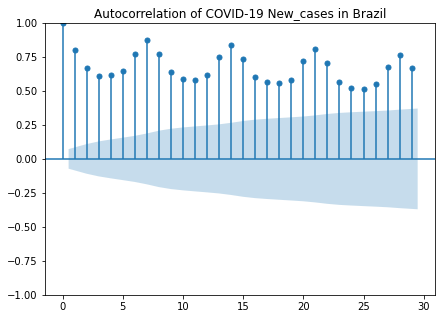

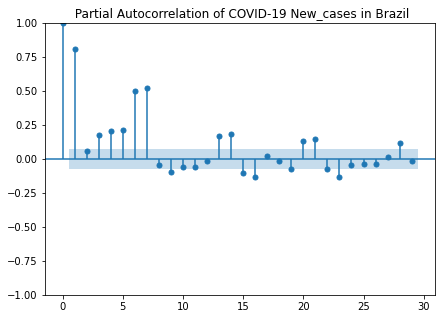

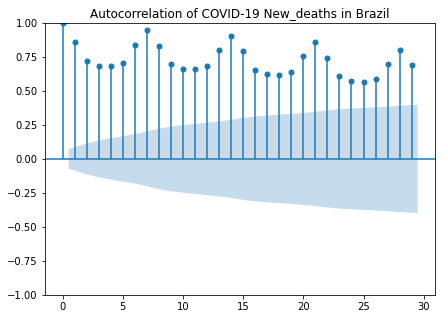

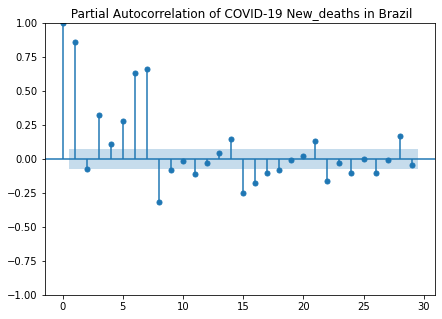

In [15]:
for metric in ["New_cases", "New_deaths"]:
    plt.rc("figure", figsize=(7,5))
    sm.graphics.tsa.plot_acf(aux_df[metric], title=f'Autocorrelation of COVID-19 {metric} in {country}')
    
    plt.rc("figure", figsize=(7,5))
    sm.graphics.tsa.plot_pacf(aux_df[metric], title=f' Partial Autocorrelation of COVID-19 {metric} in {country}');

In the Autocorrelation plots, we can see there is a clear seasonality of one week in the data. This may be because part of the tests get accumulated during weekends and their results get released during the week. In order to eliminate this seasonality that is artificially introduced in the data by how it is collected, we will resample our data in weeks, so our model is able to learn its patterns without external influence.

First, we will drop some of the columns that are not meaningful to our analysis:

In [16]:
df.drop(columns=["Country_code", "WHO_region", "Day_of_week", "Cumulative_cases", "Cumulative_deaths"], inplace=True)

Next, we will add the column "Country" as a level in our DataFrame. This is necessary, because we will index our DataFrame with the datetime object it refers to, ensuring there is only one row for each date in order to successfully resample the DataFrame in weekly intervals.

In [17]:
countries = pd.unique(df["Country"])

df_list = []
for c in countries:
    temp_df = df.loc[df["Country"] == c]
    temp_df.pop("Country")
    date_time = pd.to_datetime(temp_df.pop('Date_reported'), format='%Y.%m.%d')
    temp_df.index = date_time
    df_list.append(temp_df)

processed = pd.concat(df_list, axis=1, keys=(countries))

In [18]:
processed
#mudar para block

Afghanistan              Albania              Algeria  \
                New_cases New_deaths New_cases New_deaths New_cases   
Date_reported                                                         
2020-01-03              0          0         0          0         0   
2020-01-04              0          0         0          0         0   
2020-01-05              0          0         0          0         0   
2020-01-06              0          0         0          0         0   
2020-01-07              0          0         0          0         0   
...                   ...        ...       ...        ...       ...   
2022-01-06             38          1      1236          4       462   
2022-01-07              0          0      1648          5       410   
2022-01-08              0          0      1781          0       491   
2022-01-09              0          0      1801          4       426   
2022-01-10            136          6      1207          3       415   

                         American Samoa              Andorra             ...  \
              New_deaths      New_cases New_deaths New_cases New_deaths  ...   
Date_reported                                                            ...   
2020-01-03             0              0          0         0          0  ...   
2020-01-04             0              0          0         0          0  ...   
2020-01-05             0              0          0         0          0  ...   
2020-01-06             0              0          0         0          0  ...   
2020-01-07             0              0          0         0          0  ...   
...                  ...            ...        ...       ...        ...  ...   
2022-01-06             7              0          0       487          0  ...   
2022-01-07             8              0          0      1119          0  ...   
2022-01-08             7              0          0         0          0  ...   
2022-01-09             5              0          0         0          0  ...   
2022-01-10             9              0          0         0          0  ...   

               Viet Nam            Wallis and Futuna                Yemen  \
              New_cases New_deaths         New_cases New_deaths New_cases   
Date_reported                                                               
2020-01-03            0          0                 0          0         0   
2020-01-04            0          0                 0          0         0   
2020-01-05            0          0                 0          0         0   
2020-01-06            0          0                 0          0         0   
2020-01-07            0          0                 0          0         0   
...                 ...        ...               ...        ...       ...   
2022-01-06        17017        230                 0          0         3   
2022-01-07        25842        169                 0          0         0   
2022-01-08        16278        233                 0          0         0   
2022-01-09        16553        240                 0          0         0   
2022-01-10        23181        202                 0          0        51   

                            Zambia             Zimbabwe             
              New_deaths New_cases New_deaths New_cases New_deaths  
Date_reported                                                       
2020-01-03             0         0          0         0          0  
2020-01-04             0         0          0         0          0  
2020-01-05             0         0          0         0          0  
2020-01-06             0         0          0         0          0  
2020-01-07             0         0          0         0          0  
...                  ...       ...        ...       ...        ...  
2022-01-06             1      8770         19      1379         14  
2022-01-07             0      4096         10      1121         16  
2022-01-08             0      4189          8      1104     

Finally, we will resample our data in weekly intervals using the Pandas ``.sum()`` function. You could also use other functions, such as mean, median, min, max, etc.

In [19]:
panel1 = panel.from_single_level(df, lookback=7, horizon=7, gap=0, asset_column="Country", index_name="Date_reported")

In [20]:
panel1.x.mean()

TypeError: object of type 'function' has no len()

In [ ]:
processed = processed.resample(rule='W').sum()

In [ ]:
processed

Notice that we must drop the first and last rows in our DataFrame, because these weekly observations are not complete (less than seven measured days), which could introduce noise in the models. 

In [ ]:
processed.drop(['2020-01-05', '2022-01-16'], inplace=True)

Now that we have eliminated the artificial seasonal trend, let's take a look at how our time series looks life after resampling:

In [ ]:
for metric in ["New_cases", "New_deaths"]:    
    plt.figure(figsize=(15, 5))
    plt.plot(processed[country][metric])
    plt.title(f'{metric} of COVID-19 in {country}')
    plt.grid(True)
    plt.legend([metric])
    plt.show()

By eliminating the artificial weekly seasonality, our data looks like a much more "well-behaved" function, leading us to a simpler forecasting task. 

The last step in preparing our data for training models with Wavy is to determine what is the forecasting question you want to answer. More information on simple forecasting methods can be found in [this resource](https://otexts.com/fpp2/simple-methods.html), but in this case we will use a **difference method**, which models the the amount of change over time instead of modelling the data itself.

In [ ]:
differenced = processed.pct_change()

In [ ]:
differenced

In [ ]:
import wavy

In [ ]:
differenced

In [ ]:
my_panel = wavy.from_data(differenced, lookback=3, horizon=1, assets=["Brazil"], channels="New_deaths")

In [ ]:
my_panel = my_panel.dropinvalid()

In [ ]:
my_panel.start

In [ ]:
differenced = differenced.dropna()

for metric in ["New_cases", "New_deaths"]:
    plt.rc("figure", figsize=(7,5))
    sm.graphics.tsa.plot_acf(differenced[country][metric], title=f'Autocorrelation of COVID-19 {metric} in {country}')
    
    plt.rc("figure", figsize=(7,5))
    sm.graphics.tsa.plot_pacf(differenced[country][metric], title=f' Partial Autocorrelation of COVID-19 {metric} in {country}');

In [ ]:
for metric in ["New_cases", "New_deaths"]:    
    plt.figure(figsize=(15, 5))
    plt.plot(differenced[country][metric])
    plt.title(f'{metric} of COVID-19 in {country}')
    plt.grid(True)
    plt.legend([metric])
    plt.show()

We will, once again, check for stationarity, concluding that both of our time series are now stationary:

In [ ]:
new_cases = differenced[country]['New_cases'].values

result = adfuller(new_cases)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [ ]:
new_cases = differenced[country]['New_deaths'].values

result = adfuller(new_cases)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Now that our data is prepared and we have a clearer understanding about its behavior, it's time for us to load it into Wavy and train models with it.

## Loading data into a Wavy panel:

Levels in Wavy are organized into **assets** and **channels**. Assets are the highest level of data organization and can have many channels. In this case, assets are the countries present in the DataFrame and channels are the values we want to study, namely the variation in the numbers of new cases and new deaths.

A **Panel** is an object that has several functionalities that make it easier to work with time series. A Panel contains a list of pairs, representing an input and output sample x and y (controlled by the parameters **lookback**, **horizon** and **gap**), avoiding data leakage that may happen when working only with Pandas.

There are a few ways of loading data into a Panel: from a single DataFrame, be it single or multi level, as well as from two DataFrames to be assigned to x and y. Because this is one single level DataFrame, we will use the ``from_single_level`` function. For more details on loading data, see the documentation (colocar link).

In [21]:
my_panel = panel.from_data(differenced, lookback=3, horizon=1, gap=0, 
                           assets=['Brazil'], 
                           channels=['New_deaths'],
                          remove_invalid=False)

NameError: name 'differenced' is not defined

With a single function, we were able to: 
- separate the assets and channels we want to work with from the rest of the data;
- set datetime objects as the index;
- set input and output pairs in order to train models with it.

We can access the attributes of a Panel through its properties:

In [ ]:
print(my_panel.assets)
print(my_panel.channels)
print(my_panel.horizon)
print(my_panel.lookback)
print(my_panel.gap)
print(my_panel.index[:10])
print(my_panel.start) #First index
print(my_panel.end)   #Last index

We can access each section of the data with the x and y properties. Suppose you want to inspect the last section of your input data:

In [ ]:
my_panel.x[-1]

And the last section of your output data:

In [ ]:
my_panel.y[-1]

You can use the ``findinvalid()`` function in order to find the ``NA``, ``NaN`` and ``Inf`` values indices in your data:

In [ ]:
my_panel.findinvalid()

The items returned in the list correspond to the indices that contain invalid values. In this case, the list is returned empty, because there NaN values were removed prior to loading the data into a panel. There are a few ways of dealing with invalid values using Wavy: 
- by setting ``remove_invalid=True`` when loading the data into a panel
- by removing them from the data using the function ``drop_invalid()`` 
- or filling ``ǸaN`` values with the ``fillna`` function.

We can plot out input/output pairs in steps with the ``plot_slider()`` function:

In [ ]:
my_panel.plot_slider()

### Training models:

The first step in training a model in splitting your data into training, test and validation sets. Wavy allows you to do that very easily with the ``set_training_split`` function, with the advantage of not allowing any data to leak between sets

In [ ]:
my_panel.y  = my_panel.y > 0

In [ ]:
my_panel.y[0]

In [ ]:
my_panel.set_training_split(val_size=0.2, test_size=0.15)

You can then access each set through the ``train``, ``test`` and ``val`` properties

In [ ]:
train = my_panel.train
test = my_panel.test
val = my_panel.val

In [ ]:
train.x[-1]

### Baseline model

After you have split your data into train, test and validation sets, it is important to set a baseline performance which provides a point of comparison to all other models you will train later. Baseline models are often called naive forecasting, because it assumes no prior knowledge of the data. One of the approaches to do that is to assume simply that the value of the time series at a point ``t`` is the same as the value at the point ``t-h``, where h is the horizon previously set. If a model acheives performance at or below baseline levels, it needs reassessing. More information on setting a baseline model can be found [here](https://machinelearningmastery.com/how-to-develop-baseline-forecasts-for-multi-site-multivariate-air-pollution-time-series-forecasting/).

In [ ]:
baseline = model.Baseline(my_panel, metrics=['SE', 'MSE', 'RMSE'])

In [ ]:
predicted = baseline.predict()

We can plot the real and predicted validation sets in order to get a sense of how badly the naive model performs:

In [ ]:
predicted[0]

In [ ]:
my_panel.plot_slider()

In [ ]:
my_panel.test.y.tensor3d

In [ ]:
for asset in my_panel.assets:
    for channel in my_panel.channels:
        plt.figure(figsize=(15, 5))
        plt.plot(predicted.as_dataframe()[asset][channel].values)
        plt.plot(test.y.as_dataframe()[asset][channel].values)
        plt.legend(["predicted", "actual"])        
        plt.grid(True)
        plt.title(f'{channel} of COVID-19 in {asset}')
        plt.show()

Then, get the metrics through the ``evaluate`` function

In [ ]:
model_metrics = baseline.evaluate()

print(f'''SE: {model_metrics[0]} \n 
MSE: {model_metrics[1]} \n
RMSE: {model_metrics[2]}''')

From now on, any model we train must achieve SE, MSE and RMSE values **lower** than those shown above.

### Dense Model:

Now that we have set a baseline, we will train a simple neural network model. This can be done with the DenseModel function. We will perform a grid search to find a number of layers and nodes that is able to learn the patterns in our data successfully. Because this is a regression problem, we will use a ReLU activation function in all layers, except for the last one, where we will use a linear activation function. For the loss function, we will use MSE.

In [ ]:
dense_layers = range(1, 10)
dense_units = range(1, 10)

layers = []
units = []
MSE = []
MAE = []
for layer in dense_layers:
    for unit in dense_units:
        densemodel = model.DenseModel(my_panel, model_type="regression", 
                                   dense_layers=layer, dense_units=unit, 
                                   optimizer='adam', loss='MSE', 
                                   activation='relu', last_activation='linear')
        densemodel.fit()
        validation = densemodel.evaluate('val')
        layers.append(layer)
        units.append(unit)
        MSE.append(validation[0])
        MAE.append(validation[1])
        
model_info = pd.DataFrame({"layers": layers,
                          "units": units,
                          "MSE": MSE,
                          "MAE": MAE})

model_info.sort_values(by="MSE", ascending=True, inplace=True)

In [ ]:
model_info.head()

We found that the Dense model that is better able to predict our validation test is one with 9 layers of 1 unit each (I have played around with different values and it sounds about accurate). The MSE for this model is slightly lower than that of our baseline model, which is still far from ideal, but expected for this type of model. Let's train and fit it again with our selected parameters and plot the difference between actual and predicted values:

In [ ]:
my_panel = my_panel[1:]

In [ ]:
my_panel.findinvalid()

In [ ]:
densemodel = model.DenseModel(my_panel, model_type="classifier")

densemodel.fit()
predicted_validation = densemodel.predict_val()

In [ ]:
densemodel = model.DenseModel(my_panel, model_type="regression", 
                            dense_layers=9, dense_units=1, 
                            optimizer='adam', loss='MSE')
densemodel.fit()
predicted_validation = densemodel.predict_val()

In [ ]:
import wavy

In [ ]:
regression = wavy.LinearRegression(my_panel)

In [ ]:
regression.fit()

In [ ]:
for asset in my_panel.assets:
    for channel in my_panel.channels:
        plt.figure(figsize=(15, 5))
        plt.plot(predicted_validation.as_dataframe()[asset][channel].values)
        plt.plot(val.y.as_dataframe()[asset][channel].values)
        plt.legend(["predicted", "actual"])        
        plt.grid(True)
        plt.title(f'{channel} of COVID-19 in {asset}')
        plt.show()

Because our neural network was optimized to minimize the mean squared error over all of the time series, it tends to predict values around zero, which is not what we intended. Let's try again with a Convolutional neural network, which is designed to give more weight to relationships between data points that are closer together:

## ConvModel

A convolutional neural network is preferred over a deep neural network for this type of task, because it takes into account the fact that the relationships between data points that are closer together are more important than points that are far apart for time series forecasting. We will perform the same kind of grid search we have performed for the DenseModel to figure out the optimal hyperparameters for this task.

In [ ]:
conv_layers = range(10)
conv_filters = [2^n for n in range(5)]
kernel_size = range(1, 12, 3)
dense_layers = range(3)
dense_units = range(10)

c_layers = []
filters = []
k_size = []
d_layers = []
d_units = []
MSE = []
MAE = []
for layer in conv_layers:
    for f in conv_filters:
        for k in kernel_size:
            for l in dense_layers:
                for u in dense_units:

                    convmodel = model.ConvModel(my_panel, model_type="regression", 
                                               conv_layers=layer, conv_filters=f, kernel_size=k,
                                                dense_layers=l, dense_units=u, optimizer='adam', 
                                                loss='MSE', activation='relu', last_activation='linear')
                    convmodel.fit()
                    validation = convmodel.evaluate('val')
                    c_layers.append(layer)
                    filters.append(f)
                    k_size.append(k)
                    d_layers.append(l)
                    d_units.append(u)
                    MSE.append(validation[0])
                    MAE.append(validation[1])
        
conv_model_info = pd.DataFrame({"conv_layers": c_layers,
                           "conv_filters": filters,
                           "kernel_size": k_size,
                           "dense_layers": d_layers,
                           "dense_units": d_units,
                          "MSE": MSE,
                          "MAE": MAE})

conv_model_info.sort_values(by="MSE", ascending=True, inplace=True)

In [ ]:
convmodel = model.ConvModel(my_panel, model_type="regression")

In [ ]:
convmodel.fit()

In [ ]:
predicted_validation = convmodel.predict_val()

In [ ]:
for asset in my_panel.assets:
    for channel in my_panel.channels:
        plt.figure(figsize=(15, 5))
        plt.plot(predicted_validation.as_dataframe()[asset][channel].values)
        plt.plot(val.y.as_dataframe()[asset][channel].values)
        plt.legend(["predicted", "actual"])        
        plt.grid(True)
        plt.title(f'{channel} of COVID-19 in {asset}')
        plt.show()

In [ ]:
convmodel = model.ConvModel(my_panel, model_type="regression")

In [ ]:
import wavy

In [ ]:
teste.assets